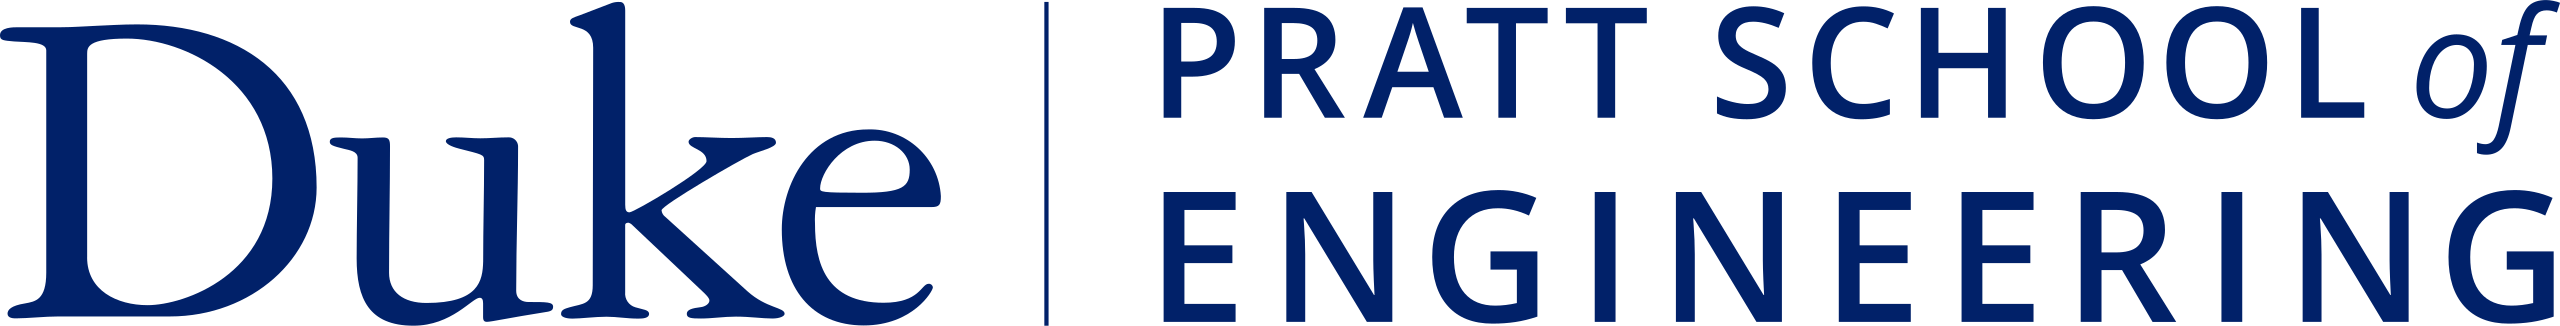
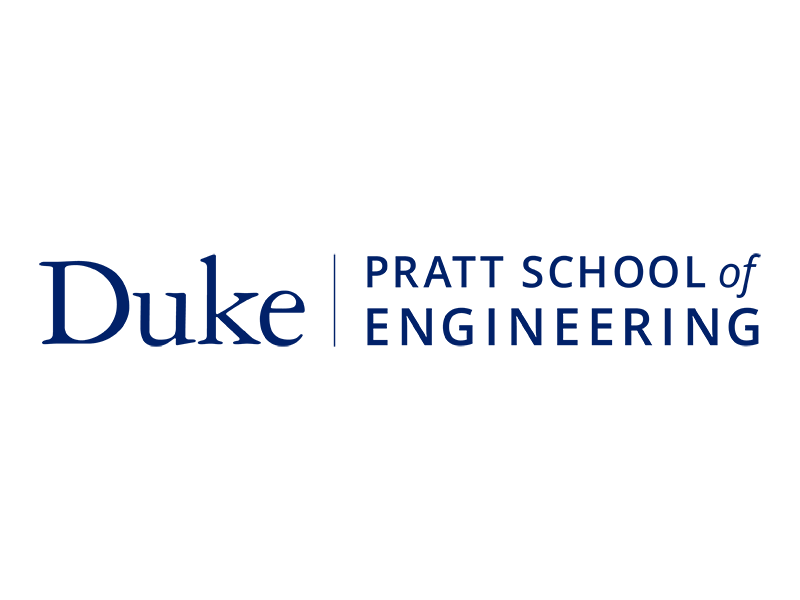

# FINTECH 545 Quantitative Risk Management
## Project 1

### Keese Phillips

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keesephillips/quantitative_risk_management/blob/main/Project01/notebook.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "quantitative_risk_management"
git_path = 'https://github.com/keesephillips/quantitative_risk_management'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'Project01'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

## Problem 1

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.stats import shapiro
from scipy.stats import norm, t

data = pd.read_csv('data/problem1.csv')
X = data['X'].values
data.head()

,X
0,-0.118037
1,0.149343
2,-0.083849
3,-0.025407
4,0.119084


### A

In [118]:
# Calculation of moments

# Simulate based on the defined Distribution above, N(0,1)
# Expect  μ = 0, 
#       σ^2 = 1,
#      skew = 0,
#      kurt = 3 (excess = 0)

def first4Moments(sample):
    n = len(sample)
    
    # mean
    μ_hat = np.sum(sample) / n
    
    # remove the mean from the sample
    sim_corrected = sample - μ_hat
    cm2 = np.sum(sim_corrected**2) / n
    
    # variance
    σ2_hat = np.sum(sim_corrected**2) / (n-1)
    
    # skew
    skew_hat = np.sum(sim_corrected**3) / n / np.sqrt(cm2**3)
    
    # kurtosis
    kurt_hat = np.sum(sim_corrected**4) / n / (cm2**2)
    
    excessKurt_hat = kurt_hat - 3
    
    return μ_hat, σ2_hat, skew_hat, excessKurt_hat

m, s2, sk, k = first4Moments(X)

print(f"Mean {m} ({np.mean(X)})")
print(f"Variance {s2} ({np.var(X, ddof=1)})")
print(f"Skew {sk} ({stats.skew(X)})")
print(f"Kurtosis {k} ({stats.kurtosis(X, fisher=True)})")

Mean 0.05019795790476916 (0.05019795790476916)
Variance 0.010332476407479588 (0.010332476407479588)
Skew 0.12044471191944014 (0.1204447119194402)
Kurtosis 0.2229270674503816 (0.2229270674503816)


### B

1000


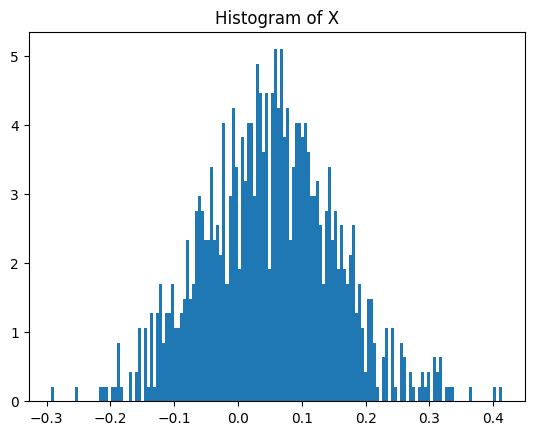

In [119]:
print(len(X))
plt.hist(X, bins=150, density=True)
plt.title("Histogram of X")
plt.show()

### C

Normal Distribution Parameters:
Mean: 0.05019795790476916
Standard Deviation: 0.10159795239606018
T-Distribution Parameters:
Degrees of Freedom: 28.710217746626604
Location: 0.04986674895784832
Scale: 0.09800129451692283


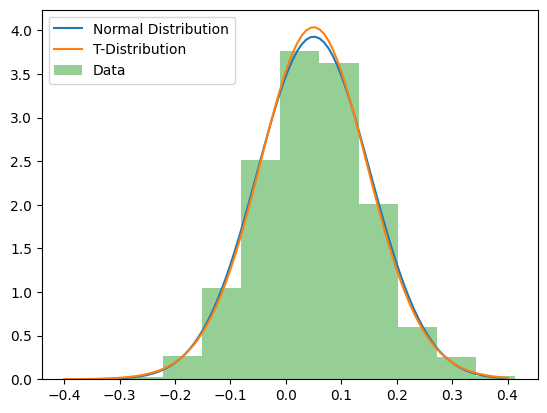

In [120]:
# Fit Normal Distribution 
norm_params = norm.fit(X)
print("Normal Distribution Parameters:")
print("Mean:", norm_params[0])
print("Standard Deviation:", norm_params[1])

# Fit T-Distribution
t_params = t.fit(X)
print("T-Distribution Parameters:")
print("Degrees of Freedom:", t_params[0])
print("Location:", t_params[1])
print("Scale:", t_params[2])

x = np.linspace(-0.4, 0.4, 100)
norm_pdf = norm.pdf(x, *norm_params)
t_pdf = t.pdf(x, *t_params)

plt.plot(x, norm_pdf, label="Normal Distribution")
plt.plot(x, t_pdf, label="T-Distribution")
plt.hist(X, density=True, alpha=0.5, label="Data")
plt.legend()
plt.show()


## Problem 2

In [121]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/problem2.csv')
data.head()

,x1,x2,x3,x4,x5
0,0.378172,0.508313,NaN,0.610538,NaN
1,0.858478,0.758142,NaN,NaN,NaN
2,-0.218954,-0.015334,-0.261880,NaN,-0.230148
3,-0.370442,-0.424702,-0.535312,NaN,-0.226233
4,0.717732,0.664195,NaN,NaN,0.914107


### A

In [122]:
def pairwise_covariance(data):
    # Initialize an empty matrix to store the covariance values
    cov_matrix = np.zeros((data.shape[1], data.shape[1]))
    
    # Iterate over each pair of columns
    for i in range(data.shape[1]):
        for j in range(i, data.shape[1]):
            # Find the common indices where both columns have no missing values
            common_idx = np.logical_and(data.iloc[:, i].notna(), data.iloc[:, j].notna())
            
            common_idx = [index for index in range(len(common_idx)) if common_idx[index]]
            
            # Calculate the covariance for the current pair
            if np.sum(common_idx) > 0:
                cov_matrix[i, j] = np.cov(data.iloc[common_idx, i], data.iloc[common_idx, j])[0, 1]
                cov_matrix[j, i] = cov_matrix[i, j]  # Symmetry
            
    return cov_matrix

cov_matrix = pairwise_covariance(data)
pd.DataFrame(cov_matrix).head(50)


,0,1,2,3,4
0,1.470484,1.454214,0.877269,1.903226,1.444361
1,1.454214,1.252078,0.539548,1.621918,1.237877
2,0.877269,0.539548,1.272425,1.171959,1.091912
3,1.903226,1.621918,1.171959,1.814469,1.589729
4,1.444361,1.237877,1.091912,1.589729,1.396186


### B

In [123]:
def is_psd(data):
    eigenvalues = np.linalg.eigvals(data)
    return np.all(eigenvalues >= -1e-8)

if is_psd(cov_matrix):
    print("The matrix is semi-positive definite.")
else:
    print("The matrix is not semi-positive definite.")
    print(np.linalg.eigvals(cov_matrix))


The matrix is not semi-positive definite.
[ 6.78670573  0.83443367 -0.31024286  0.02797828 -0.13323183]


### C

In [124]:
def higham_correlation(corr, max_iter=100, tol=1e-8):
    n = corr.shape[0]
    Y = corr.copy()
    prev_Y = Y.copy()
    
    for i in range(max_iter):
        # Project Y onto the set of positive semi-definite matrices
        eigvals, eigvecs = np.linalg.eigh(Y)
        eigvals = np.maximum(eigvals, 0)  # Set negative eigenvalues to zero
        X = eigvecs @ np.diag(eigvals) @ eigvecs.T
        X = (X + X.T) / 2  # Ensure symmetry
        
        # Project X onto the set of matrices with unit diagonal
        Y = X.copy()
        np.fill_diagonal(Y, 1)
        
        # Check for convergence
        delta_norm = np.linalg.norm(Y - prev_Y, 'fro')
        if delta_norm < tol:
            break
        prev_Y = Y.copy()
    else:
        print(f"Warning: Did not converge within {max_iter} iterations.")
    
    return Y

def highams_covariance(cov, max_iter=100, tol=1e-8):
    cov = np.asarray(cov)
    
    if cov.ndim != 2 or cov.shape[0] != cov.shape[1]:
        raise ValueError("Input covariance matrix must be square.")
    
    diag_cov = np.diag(cov)
    if np.any(diag_cov <= 0):
        raise ValueError("Covariance matrix has non-positive values on the diagonal.")
    
    # Convert covariance to correlation matrix
    std_dev = np.sqrt(diag_cov)
    corr = cov / np.outer(std_dev, std_dev)
    
    # Apply Higham's method to find nearest PSD correlation matrix
    psd_corr = higham_correlation(corr, max_iter=max_iter, tol=tol)
    
    # Convert the PSD correlation matrix back to covariance
    psd_cov = psd_corr * np.outer(std_dev, std_dev)
    
    return psd_cov


highams_method = highams_covariance(cov_matrix)
pd.DataFrame(highams_method).head()

,0,1,2,3,4
0,1.470484,1.332524,0.886817,1.628700,1.400961
1,1.332524,1.252078,0.622298,1.454230,1.217183
2,0.886817,0.622298,1.272425,1.070369,1.057808
3,1.628700,1.454230,1.070369,1.814469,1.577137
4,1.400961,1.217183,1.057808,1.577137,1.396186


In [125]:
def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    
    invSD = None
    out = a.copy()
    
    # Calculate the correlation matrix if we got a covariance
    if not np.allclose(np.diag(out), np.ones(n)):
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = np.dot(invSD, np.dot(out, invSD))

    eigval, eigvec = np.linalg.eig(out)
    val = np.matrix(np.maximum(eigval,epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    out = B*B.T
    
    # Add back the variance
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = np.dot(invSD, np.dot(out, invSD))
    
    return out

near_psd_matrix = near_psd(cov_matrix)
pd.DataFrame(near_psd_matrix).head()

,0,1,2,3,4
0,1.470484,1.327009,0.842583,1.624464,1.364833
1,1.327009,1.252078,0.555421,1.433109,1.165906
2,0.842583,0.555421,1.272425,1.052789,1.060424
3,1.624464,1.433109,1.052789,1.814469,1.544993
4,1.364833,1.165906,1.060424,1.544993,1.396186


### D

In [126]:
def covariance_overlapping(data):
    # Ensure data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    
    # Find common indices where all columns have no missing values
    common_idx = data.notna().all(axis=1)
    
    # Calculate covariance matrix using overlapping data
    cov_matrix = data.loc[common_idx].cov()
    
    return cov_matrix

cov_overlap = covariance_overlapping(cov_matrix)
cov_overlap.head()

,0,1,2,3,4
0,0.132972,0.144205,-0.021001,0.087688,0.064467
1,0.144205,0.170188,-0.039520,0.112221,0.072822
2,-0.021001,-0.039520,0.084718,-0.031758,0.003825
3,0.087688,0.112221,-0.031758,0.079924,0.046841
4,0.064467,0.072822,0.003825,0.046841,0.036917


## Problem 3

In [127]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/problem3.csv')
data.head()

,x1,x2
0,0.116393,0.290704
1,0.121387,-0.042551
2,0.004184,0.040375
3,-0.129885,-0.013411
4,-0.076053,0.077160


### A

In [128]:
data = data.values 

# Compute mean and covariance
mu = np.mean(data, axis=0)
cov = np.cov(data, rowvar=False)

print(f"Mean vector: {mu}")
print(f"Covariance matrix:")
pd.DataFrame(cov).head()

Mean vector: [0.04600157 0.09991502]
Covariance matrix:


,0,1
0,0.010162,0.004924
1,0.004924,0.020284


### B

In [129]:
# Method 1: Conditional distribution formula
x1_cond = 0.6

# Partition parameters
mu1, mu2 = mu
sig11 = cov[0,0]
sig12 = cov[0,1]
sig22 = cov[1,1]

# Conditional parameters
cond_mu = mu2 + (sig12/sig11)*(x1_cond - mu1)
cond_var = sig22 - (sig12**2)/sig11

print(f"Conditional Mean (Formula): {cond_mu:.4f}")
print(f"Conditional Variance (Formula): {cond_var:.4f}")

Conditional Mean (Formula): 0.3683
Conditional Variance (Formula): 0.0179


In [130]:
# Method 2: OLS Regression
X = sm.add_constant(data[:, 0])  # X1 values with intercept
model = sm.OLS(data[:, 1], X).fit()
ols_intercept = model.params[0]
ols_slope = model.params[1]
resid_var = np.var(model.resid, ddof=2)  

print(f"OLS Slope: {ols_slope:.4f} ({sig12/sig11:.4f})")
print(f"OLS Intercept: {ols_intercept:.4f} ({mu2 - (sig12/sig11)*mu1:.4f})")
print(f"Residual Variance: {resid_var:.4f} ({cond_var:.4f})")

OLS Slope: 0.4845 (0.4845)
OLS Intercept: 0.0776 (0.0776)
Residual Variance: 0.0179 (0.0179)


### C

Simulated Mean: 0.3687 (Target: 0.3683)
Simulated Variance: 0.0179 (Target: 0.0179)
Mean Absolute Error: 0.000403
Variance Absolute Error: 0.000031


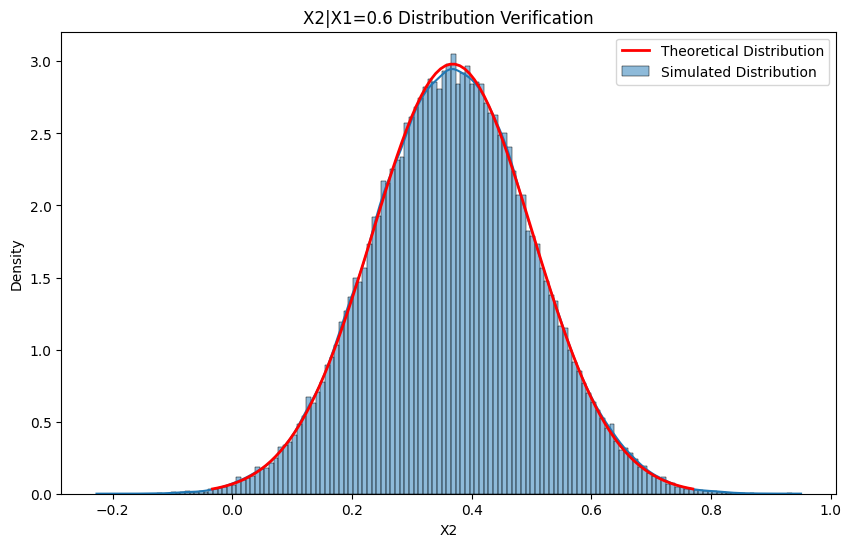

In [131]:
# Perform Cholesky decomposition
L = np.linalg.cholesky(cov)
L11 = L[0,0]
L21 = L[1,0]
L22 = L[1,1]

n_sim = 100000

# Compute fixed Z1 component
z1 = (x1_cond - mu1)/L11

# Simulate Z2 values
z2 = np.random.normal(size=n_sim)

# Compute conditional X2 values
x2_sim = mu2 + L21*z1 + L22*z2

sim_mu = np.mean(x2_sim)
sim_var = np.var(x2_sim)

print(f"Simulated Mean: {sim_mu:.4f} (Target: {cond_mu:.4f})")
print(f"Simulated Variance: {sim_var:.4f} (Target: {cond_var:.4f})")
print(f"Mean Absolute Error: {abs(sim_mu - cond_mu):.6f}")
print(f"Variance Absolute Error: {abs(sim_var - cond_var):.6f}")

plt.figure(figsize=(10, 6))
sns.histplot(x2_sim, kde=True, stat='density', label='Simulated Distribution')
x = np.linspace(cond_mu-3*np.sqrt(cond_var), cond_mu+3*np.sqrt(cond_var), 100)
plt.plot(x, norm.pdf(x, cond_mu, np.sqrt(cond_var)), 'r-', lw=2, label='Theoretical Distribution')
plt.title('X2|X1=0.6 Distribution Verification')
plt.xlabel('X2')
plt.ylabel('Density')
plt.legend()
plt.show()

## Problem 4

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from io import StringIO


data = pd.read_csv('data/problem4.csv')
y = data['y']
data.head()

,y
0,5.050216
1,5.019310
2,5.016443
3,5.106906
4,4.993011


### A

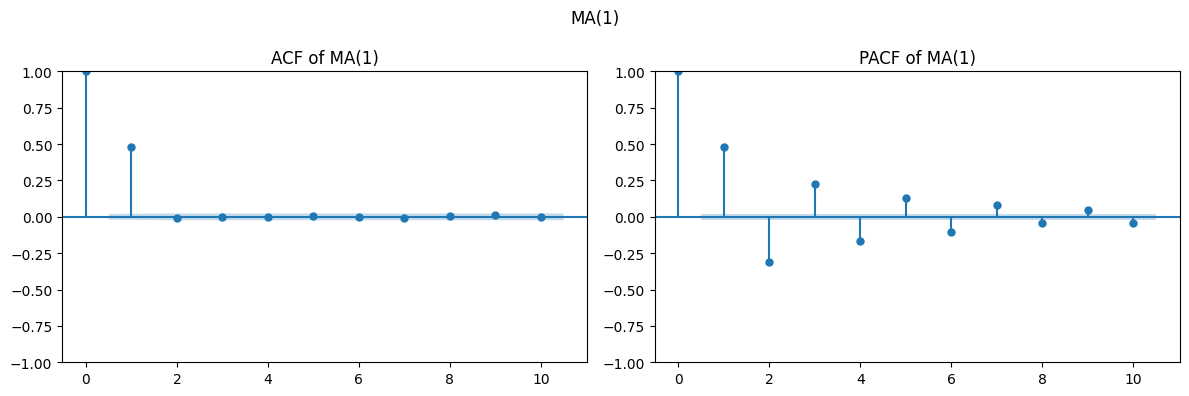

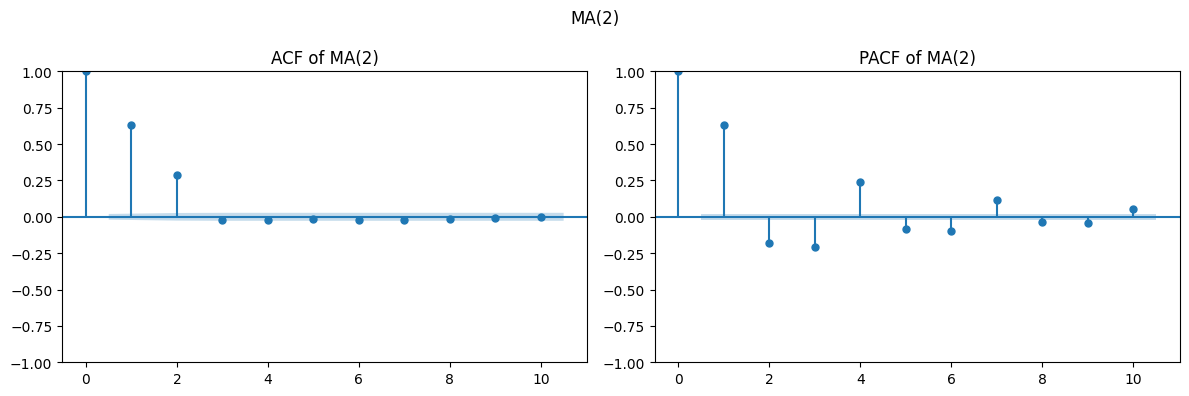

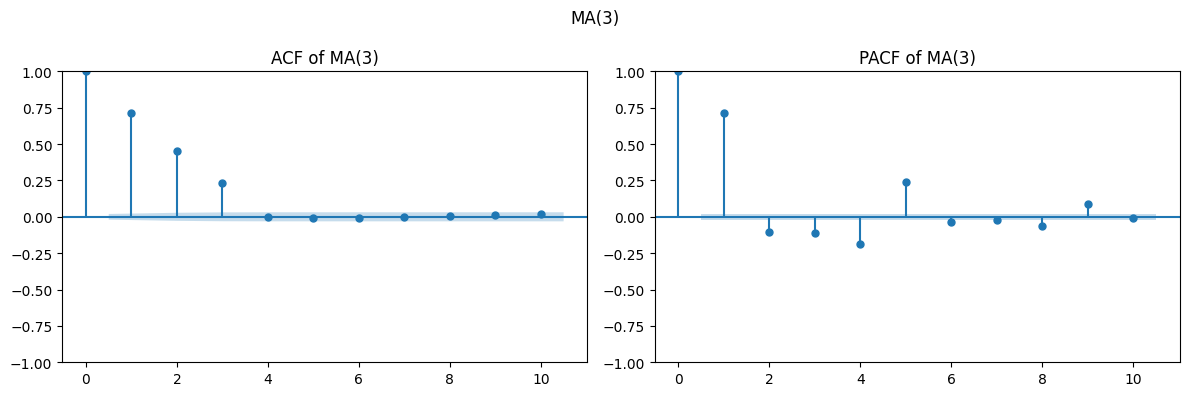

In [133]:
θ = [1, 0.8, 0.6, 0.5]  
n_sim = 10000

# Generate MA(1) process
ma1 = ArmaProcess(ar=[1], ma=θ[:2])
ma1_sim = ma1.generate_sample(nsample=n_sim)  

# ACF and PACF plots for MA(1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ma1_sim, lags=10, ax=axes[0], title='ACF of MA(1)')
plot_pacf(ma1_sim, lags=10, ax=axes[1], title='PACF of MA(1)', method='ywm')
plt.suptitle('MA(1)')
plt.tight_layout()
plt.show()

# Generate MA(2) process
ma2 = ArmaProcess(ar=[1], ma=θ[:3])
ma2_sim = ma2.generate_sample(nsample=n_sim)  

# ACF and PACF plots for MA(2)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ma2_sim, lags=10, ax=axes[0], title='ACF of MA(2)')
plot_pacf(ma2_sim, lags=10, ax=axes[1], title='PACF of MA(2)', method='ywm')
plt.suptitle('MA(2)')
plt.tight_layout()
plt.show()

# Generate MA(3) process
ma3 = ArmaProcess(ar=[1], ma=θ[:4])
ma3_sim = ma3.generate_sample(nsample=n_sim)  

# ACF and PACF plots for MA(3)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ma3_sim, lags=10, ax=axes[0], title='ACF of MA(3)')
plot_pacf(ma3_sim, lags=10, ax=axes[1], title='PACF of MA(3)', method='ywm')
plt.suptitle('MA(3)')
plt.tight_layout()
plt.show()

### B

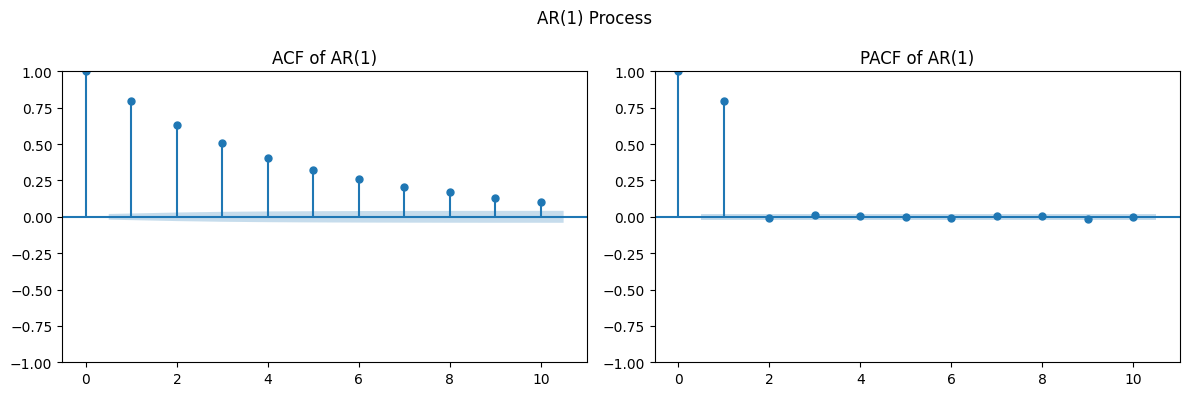

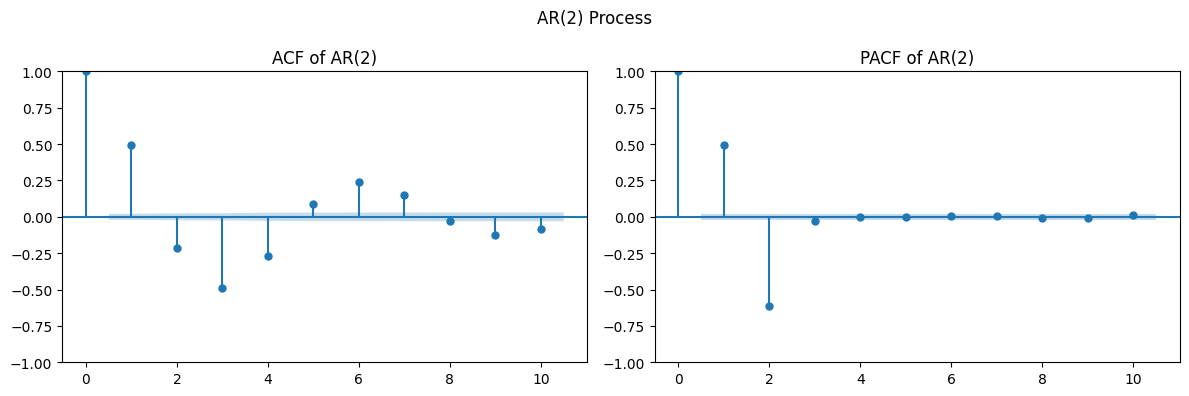

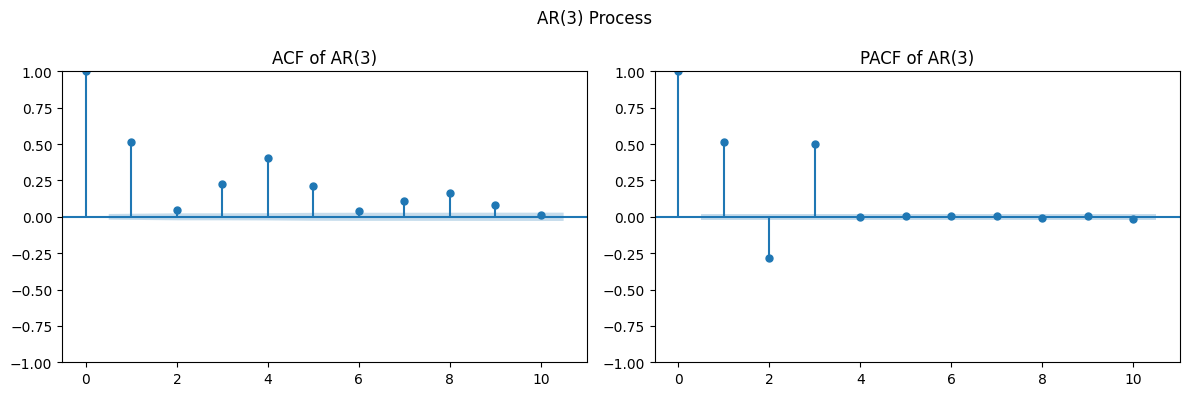

In [134]:
Φ = [1, -0.8, 0.6, -0.5]  
n_sim = 10000

# Generate AR(1) 
ar1 = ArmaProcess(ar=Φ[:2], ma=[1])  
ar1_sim = ar1.generate_sample(nsample=n_sim)

# Plot ACF/PACF for AR(1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ar1_sim, lags=10, ax=axes[0], title='ACF of AR(1)')
plot_pacf(ar1_sim, lags=10, ax=axes[1], title='PACF of AR(1)', method='ywm')
plt.suptitle('AR(1) Process')
plt.tight_layout()
plt.show()

# Generate AR(2) 
ar2 = ArmaProcess(ar=Φ[:3], ma=[1]) 
ar2_sim = ar2.generate_sample(nsample=n_sim)

# Plot ACF/PACF for AR(2)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ar2_sim, lags=10, ax=axes[0], title='ACF of AR(2)')
plot_pacf(ar2_sim, lags=10, ax=axes[1], title='PACF of AR(2)', method='ywm')
plt.suptitle('AR(2) Process')
plt.tight_layout()
plt.show()

# Generate AR(3) 
ar3 = ArmaProcess(ar=Φ[:4], ma=[1])  
ar3_sim = ar3.generate_sample(nsample=n_sim)

# Plot ACF/PACF for AR(3)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ar3_sim, lags=10, ax=axes[0], title='ACF of AR(3)')
plot_pacf(ar3_sim, lags=10, ax=axes[1], title='PACF of AR(3)', method='ywm')
plt.suptitle('AR(3) Process')
plt.tight_layout()
plt.show()

### C

y.describe()
count    1000.000000
mean        4.997666
std         0.135114
min         4.598763
25%         4.902053
50%         4.996434
75%         5.095853
max         5.413747
Name: y, dtype: float64


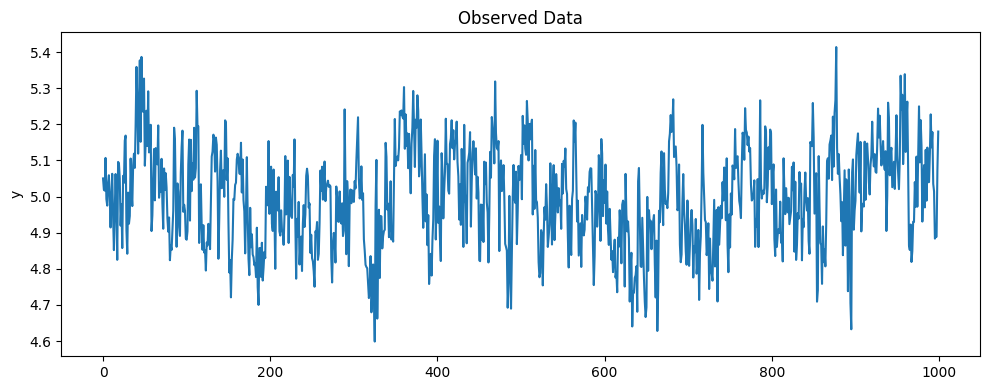

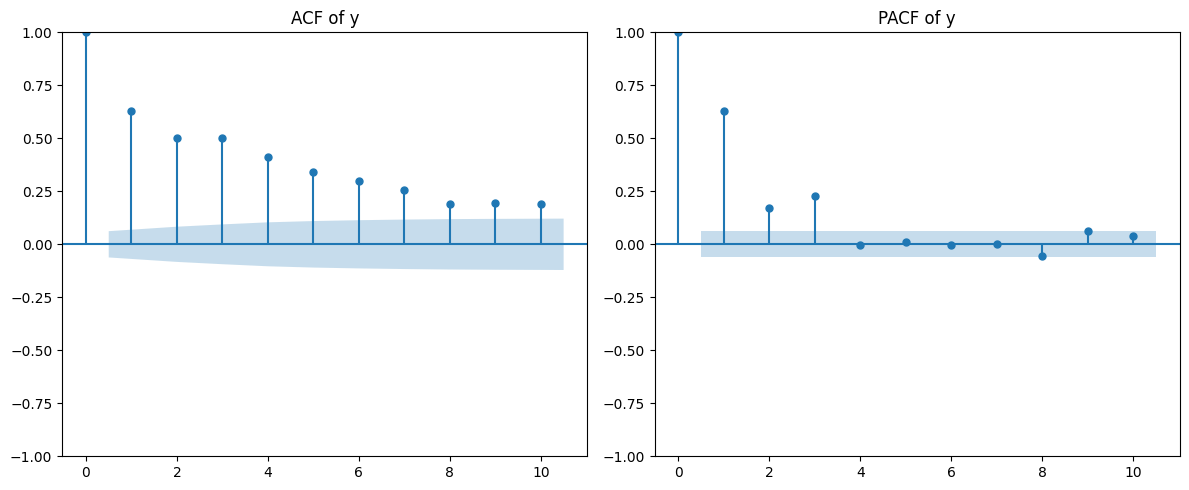

In [135]:
print("y.describe()")
print(y.describe())

plt.figure(figsize=(10, 4))
plt.plot(y,linestyle='-')
plt.title("Observed Data")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# ACF and PACF plots for y
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(y, lags=10, ax=axes[0], title='ACF of y')
plot_pacf(y, lags=10, ax=axes[1], title='PACF of y', method='ywm')
plt.tight_layout()
plt.show()

### D

In [136]:
ar_models = [(p, 0, 0) for p in range(1,5) ]
ma_models = [(0, 0, q) for q in range(1,5) ]
models = ar_models + ma_models
results = []
for order in models:
    model = ARIMA(y, order=order)
    res = model.fit()
    k = order[0] + order[2]
    aicc = res.aic + (2 * k * (k + 1)) / (len(y) - k - 1)
    results.append((order, aicc))


results.sort(key=lambda x: x[1])
print("Model AICc Comparison:")
for order, aicc in results[:15]:
    print(f"ARMA{order}: {aicc:.2f}")

best_model = results[0]
print(f"Best model: ARIMA{best_model[0]} with AICc {best_model[1]:.2f}")

Model AICc Comparison:
ARMA(3, 0, 0): -1746.26
ARMA(4, 0, 0): -1744.27
ARMA(2, 0, 0): -1696.08
ARMA(0, 0, 4): -1677.54
ARMA(1, 0, 0): -1669.09
ARMA(0, 0, 3): -1645.11
ARMA(0, 0, 2): -1559.24
ARMA(0, 0, 1): -1508.92
Best model: ARIMA(3, 0, 0) with AICc -1746.26


## Problem 5

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('data/DailyReturn.csv', index_col='Date', parse_dates=['Date'])
data.head()

,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,GOOG,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.007720,0.010314,0.030318,-0.043743,-0.007924,0.021084,-0.011670,0.012214,0.051249,-0.011037,...,0.036001,0.019460,0.034628,0.016442,-0.002157,0.030420,0.076037,0.037892,0.019696,0.026626
2023-01-05,-0.011413,-0.010605,-0.032816,-0.029638,-0.023726,-0.003376,-0.021344,-0.009318,-0.029039,-0.021869,...,-0.000287,-0.018143,-0.011609,-0.003743,0.001196,-0.014553,0.009410,-0.035140,-0.012782,-0.028714
2023-01-06,0.022932,0.036794,0.041640,0.011785,0.035611,0.024263,0.013225,0.060196,0.024651,0.016019,...,0.021641,0.029012,0.010371,0.023707,-0.008028,0.016456,0.037653,0.033673,0.067640,0.020163
2023-01-09,-0.000567,0.004089,0.051753,0.009736,0.014870,-0.004230,0.007786,-0.019612,0.059349,0.007260,...,-0.018277,-0.003334,-0.041059,-0.023377,-0.030111,0.030303,-0.007222,-0.005058,0.016080,0.010713
2023-01-10,0.007013,0.004456,0.017981,0.007617,0.028732,0.027188,0.004544,-0.003398,-0.007681,0.004955,...,0.012030,0.000000,0.017410,0.005637,0.007190,0.009871,0.015082,-0.000086,0.013660,0.020539


### A

In [42]:
def populate_weights(n, λ):
    exponents = np.arange(n)  
    raw_weights = (1 - λ) * (λ ** exponents)

    cum_weights = np.sum(raw_weights)
    weights = raw_weights / cum_weights if cum_weights != 0 else np.ones(n)/n
    
    return weights, cum_weights

def exponentially_weighted_covariance(data, λ=0.97):
    n_vars = data.shape[1]
    n_obs = data.shape[0]
    ew_cov = np.zeros((n_vars, n_vars))
    
    # Generate weights based on number of observations
    weights, _ = populate_weights(n_obs, λ)
    weights = weights[::-1]
    
    # Compute weighted means for each variable
    means = np.zeros(n_vars)
    for col in range(n_vars):
        means[col] = np.average(data.iloc[:, col], weights=weights)
    
    # Compute weighted covariance
    for x in range(n_vars):
        for y in range(n_vars):
            cov = 0.0
            for i in range(n_obs):
                cov += weights[i] * (data.iloc[i, x] - means[x]) * (data.iloc[i, y] - means[y])
            ew_cov[x, y] = cov
    
    return ew_cov

ewma_cov_matrix = exponentially_weighted_covariance(data, λ=0.97)
pd.DataFrame(ewma_cov_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000072,0.000054,0.000124,0.000080,0.000112,0.000081,0.000088,0.000176,0.000234,0.000088,...,0.000040,0.000031,0.000029,0.000027,0.000026,0.000135,0.000148,0.000059,0.000127,0.000053
1,0.000054,0.000139,0.000041,0.000084,0.000081,0.000056,0.000071,0.000140,0.000173,0.000071,...,0.000008,0.000014,0.000008,0.000026,0.000003,0.000041,0.000055,0.000060,0.000084,0.000038
2,0.000124,0.000041,0.000663,0.000133,0.000196,0.000186,0.000145,0.000223,0.000235,0.000148,...,0.000038,0.000012,0.000008,-0.000009,0.000027,0.000220,0.000304,0.000014,0.000322,0.000050
3,0.000080,0.000084,0.000133,0.000161,0.000174,0.000126,0.000122,0.000196,0.000279,0.000123,...,0.000017,0.000025,0.000018,0.000024,-0.000015,0.000105,0.000151,0.000061,0.000152,0.000054
4,0.000112,0.000081,0.000196,0.000174,0.000323,0.000188,0.000201,0.000295,0.000373,0.000199,...,0.000019,0.000021,0.000013,0.000015,-0.000008,0.000188,0.000173,0.000057,0.000185,0.000071


### B

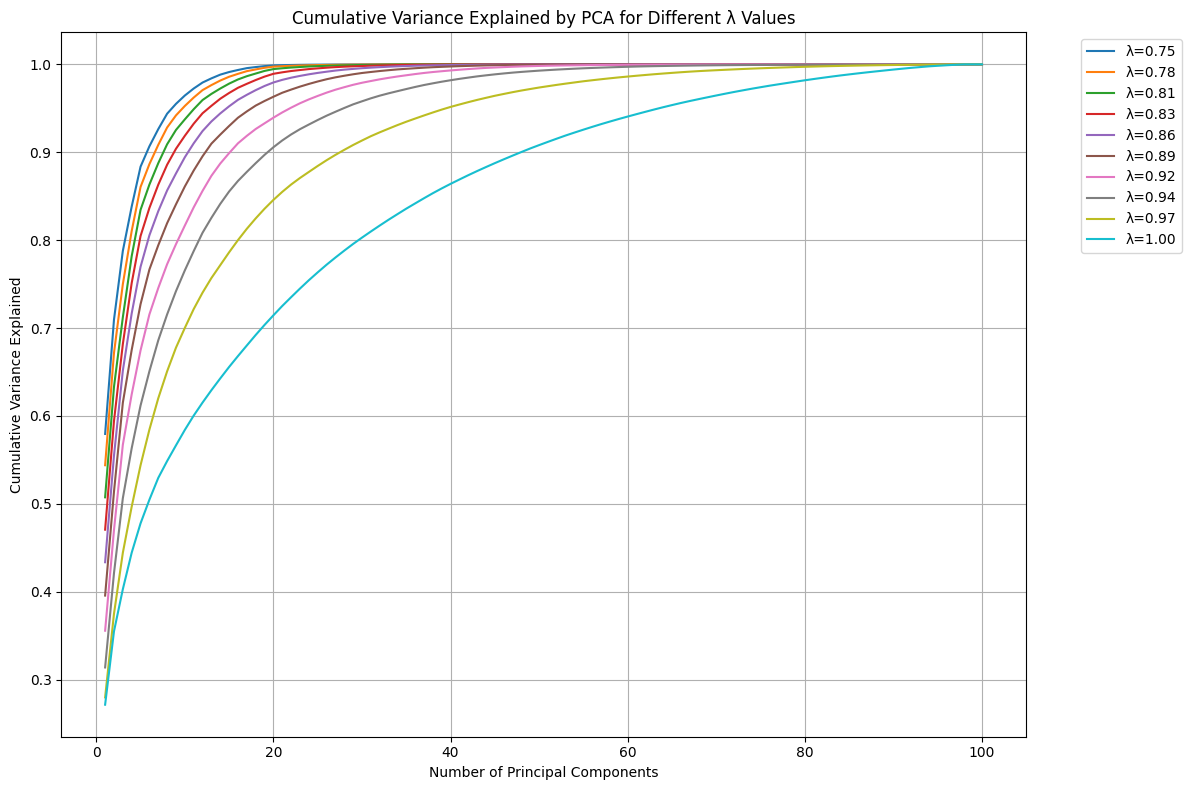

In [43]:
# Define a range of λ values
lambdas = np.linspace(0.75, 1.0, 10)  # Adjust the range and number of points as needed

plt.figure(figsize=(12, 8))

for λ in lambdas:
    # Compute exponentially weighted covariance matrix
    cov_matrix = exponentially_weighted_covariance(data, λ=λ)
    
    # Compute eigenvalues (sorted in ascending order by eigh)
    eigenvalues = np.linalg.eigh(cov_matrix)[0]
    # Reverse to descending order
    eigenvalues_sorted = eigenvalues[::-1]
    
    # Cumulative explained variance
    cumulative_variance = np.cumsum(eigenvalues_sorted) / np.sum(eigenvalues_sorted)
    
    # Plot
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
             label=f'λ={λ:.2f}')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA for Different λ Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Problem 6

In [137]:
import numpy as np
import pandas as pd
import time

data = pd.read_csv('data/problem6.csv', header=0)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,x500
0,0.005315,0.000215,-0.000777,0.000418,-0.000687,0.000166,0.000935,-0.000445,0.000826,0.000146,...,0.001210,-0.000365,0.000155,-0.000881,-0.000284,-0.000149,0.000021,0.000237,0.001169,-0.000095
1,0.000215,0.001781,0.000094,-0.000109,-0.000438,0.000523,-0.000803,0.000242,0.000596,0.000129,...,0.000212,0.000256,-0.000106,-0.000080,0.000053,-0.000190,0.000009,0.000370,0.000707,0.000139
2,-0.000777,0.000094,0.004925,0.000320,-0.000592,0.000418,-0.000195,0.000543,0.001143,-0.000326,...,-0.000634,-0.000883,-0.000068,-0.000492,0.000222,-0.000761,-0.000269,-0.000335,0.000360,-0.000124
3,0.000418,-0.000109,0.000320,0.002545,-0.000323,-0.000106,0.000165,-0.000077,-0.000186,-0.000830,...,-0.000069,-0.000187,-0.000157,-0.000183,-0.000380,0.000310,0.000172,0.000148,0.000761,0.000240
4,-0.000687,-0.000438,-0.000592,-0.000323,0.009133,-0.001379,-0.002163,-0.000677,-0.000217,0.000413,...,0.001167,0.000394,-0.000137,0.000604,-0.000234,0.001203,0.000028,0.000201,-0.001461,0.000078


### A

In [138]:
def chol_psd(a, tol=1e-8):
    a = np.array(a)
    n = a.shape[0]
    root = np.zeros_like(a)

    for j in range(n):
        s = np.dot(root[j, :j], root[j, :j]) if j > 0 else 0.0
        temp = a[j, j] - s
        if temp < 0 and abs(temp) < tol:
            temp = 0.0
        elif temp < 0:
            raise np.linalg.LinAlgError("Matrix is not positive semidefinite")
        root[j, j] = np.sqrt(temp)
        if root[j, j] > 0:
            for i in range(j+1, n):
                s = np.dot(root[i, :j], root[j, :j]) if j > 0 else 0.0
                root[i, j] = (a[i, j] - s) / root[j, j]
    return root

def simulate_cholesky(cov_matrix, n_samples=10000, epsilon=1e-5):
    n = cov_matrix.shape[0]
    
    # Add epsilon to diagonal to ensure positive definiteness
    cov_matrix = cov_matrix + epsilon * np.eye(n)
    
    root = np.linalg.cholesky(cov_matrix)
    Z = np.random.normal(size=(n, n_samples))
    X = np.dot(root, Z).T 
   
    return X, root

X_chol, root = simulate_cholesky(data)
pd.DataFrame(X_chol).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.106994,-0.088386,-0.212620,-0.024047,0.127800,0.031142,0.035479,0.003143,-0.008338,0.040514,...,0.135636,-0.061648,-0.013689,0.118273,-0.042655,0.152550,0.001024,0.031338,-0.125715,-0.002765
1,-0.118069,-0.011748,-0.055569,-0.010550,-0.010158,0.032496,-0.039434,-0.010356,-0.186653,0.040864,...,0.002391,0.061339,-0.032129,-0.001844,-0.020795,0.084621,-0.026616,-0.014998,0.095659,0.026683
2,-0.065634,-0.001779,-0.025400,-0.139324,0.088700,0.019337,-0.061191,0.017125,-0.013659,0.060208,...,-0.039006,0.113138,0.001886,-0.008169,0.044351,-0.009074,-0.018570,-0.071741,-0.067194,-0.029663
3,-0.095706,0.044616,-0.005728,-0.041974,0.053687,-0.048871,-0.193218,0.004355,0.074750,-0.050210,...,0.085604,-0.118843,0.010145,0.020923,-0.000680,0.145127,-0.026533,0.045246,0.011706,0.057921
4,-0.003332,0.026809,-0.108791,0.019585,-0.013987,0.065140,-0.084607,-0.015053,0.052330,-0.037602,...,-0.113133,-0.141966,0.021377,0.027613,-0.016509,0.086118,0.054168,-0.038098,0.014983,0.027624


### B

In [139]:
def simulate_pca(cov_matrix, n_samples=10000, variance_explained=0.75):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]  
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    k = np.argmax(cumulative_variance >= variance_explained) + 1  
    
    Z = np.random.normal(size=(k, n_samples))
    Z_scaled = Z * np.sqrt(eigenvalues[:k, np.newaxis])
    X_pca = (eigenvectors[:, :k] @ Z_scaled).T
    return X_pca

X_pca = simulate_pca(data)
pd.DataFrame(X_pca).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.007296,0.023401,-0.041675,-0.004441,0.001163,0.040230,-0.016159,-0.030928,-0.015146,-0.021473,...,-0.036511,0.152758,0.010334,0.048920,0.002713,-0.099769,0.069585,0.061292,0.118102,0.013872
1,-0.031545,-0.025934,0.047352,0.002469,-0.004629,0.046098,0.100620,-0.008057,-0.018982,-0.047008,...,-0.075745,-0.144885,-0.021379,-0.059162,0.006434,0.090052,-0.054769,-0.037448,-0.112883,-0.002080
2,-0.057689,0.034196,0.035113,-0.015313,-0.073842,0.064537,-0.050453,0.046035,-0.084183,-0.014424,...,-0.047682,0.089146,0.026975,0.010861,0.030868,-0.147761,0.028594,-0.000404,0.078765,0.001730
3,-0.021304,-0.037645,0.091554,-0.007689,-0.033254,0.003511,0.147557,0.025129,-0.005624,0.011059,...,-0.109528,-0.106459,-0.015556,-0.062134,-0.008578,0.155309,-0.044647,-0.040838,0.025507,-0.006900
4,0.063633,0.004895,-0.042809,-0.015288,0.125049,0.040981,-0.076529,0.008329,0.079894,0.083541,...,0.090063,0.099803,0.000608,0.042852,0.019899,0.005658,0.014521,0.011848,-0.029267,-0.004222


### C

In [140]:
def compute_frobenius_norms(original, cov):
    norm = np.linalg.norm(original - cov, 'fro')
    return norm

cov_chol = np.cov(X_chol, rowvar=False)
cov_pca = np.cov(X_pca, rowvar=False)

frob_chol = compute_frobenius_norms(data, cov_chol)
frob_pca = compute_frobenius_norms(data, cov_pca)

print(f"Cholesky: {frob_chol:.4f}")
print(f"PCA: {frob_pca:.4f}")

Cholesky: 0.0209
PCA: 0.0833


### D

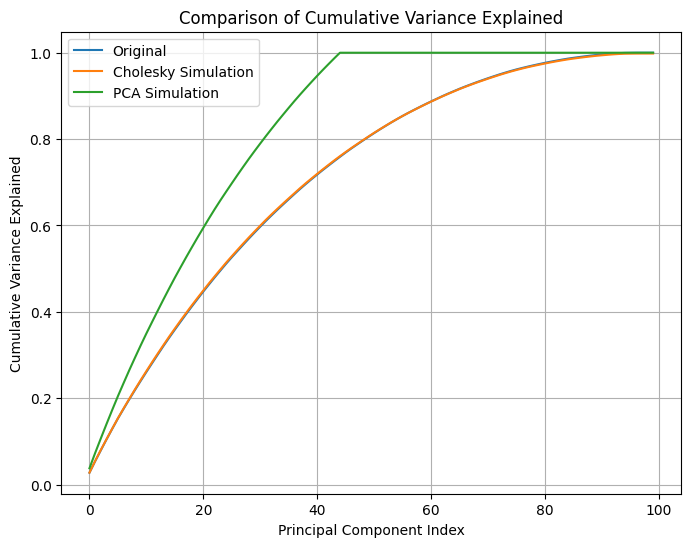

In [141]:
def cumulative_variance(cov):
    eigvals = np.linalg.eigvalsh(cov)
    eigvals_sorted = np.sort(eigvals)[::-1]
    cum_var = np.cumsum(eigvals_sorted)
    cum_ratio = cum_var / cum_var[-1]
    return eigvals_sorted, cum_ratio

eig_orig, cum_orig   = cumulative_variance(data)
eig_chol, cum_chol   = cumulative_variance(cov_chol)
eig_pca, cum_pca     = cumulative_variance(cov_pca)

plt.figure(figsize=(8,6))
plt.plot(cum_orig[:100], label='Original')
plt.plot(cum_chol[:100], label='Cholesky Simulation')
plt.plot(cum_pca[:100], label='PCA Simulation')
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Variance Explained")
plt.title("Comparison of Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.show()

### E

In [145]:
def time_simulations():
    # Time Cholesky
    start = time.time()
    X_chol, _ = simulate_cholesky(data)
    cov_chol = np.cov(X_chol, rowvar=False)
    time_chol = time.time() - start
    
    # Time PCA
    start = time.time()
    X_pca = simulate_pca(data)
    cov_pca = np.cov(X_pca, rowvar=False)
    time_pca = time.time() - start
    return time_chol, time_pca

time_chol, time_pca = time_simulations()
print(f"Cholesky: {time_chol:.4f} seconds, PCA: {time_pca:.4f} seconds")

Cholesky: 0.2392 seconds, PCA: 0.1964 seconds
